<a href="https://colab.research.google.com/github/traviz2560/CNN-ASL-kaggle/blob/main/CNN_ASL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#INSTALL

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install git+https://github.com/rwightman/pytorch-image-models.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rwightman/pytorch-image-models.git to /tmp/pip-req-build-iyn5rt37
  Running command git clone -q https://github.com/rwightman/pytorch-image-models.git /tmp/pip-req-build-iyn5rt37


#LIBRERIAS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sn
import gc

In [ ]:
import timm
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pytorch_lightning as pl
from sklearn import metrics as sk_metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#DATASET VARIABLES

In [ ]:
DRIVE_PATH = "/content/drive/MyDrive/colab_ia/DATASET"
COLAB_PATH = "/content/output"

El dataset posee imagenes de 200 x 200 px

#UNZIP DATASET

In [ ]:
OUT_PATH = DRIVE_PATH + "/output.zip"
!unzip {OUT_PATH} -d "/content"

unzip:  cannot find or open /content/drive/MyDrive/colab_ia/DATASET/output.zip, /content/drive/MyDrive/colab_ia/DATASET/output.zip.zip or /content/drive/MyDrive/colab_ia/DATASET/output.zip.ZIP.


#DATASET CLASS

In [ ]:
class my_dataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index): #indices de los batches
        if self.transform:
            x = self.transform(self.dataset[index][0])
        else:
            x = self.dataset[index][0]      
   
        y = self.dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(self.dataset)

    def __idx__(self):
        return self.dataset.class_to_idx

#DATASET SHOW

In [ ]:
path_test =  os.path.join(COLAB_PATH, 'test')
MD=my_dataset(datasets.ImageFolder(root = path_test))
print(MD.__len__())
inv_map = {v: k for k, v in MD.__idx__().items()}
plt.figure(figsize=(20, 25))
for i in range(24):
  pos = np.random.randint(MD.__len__())
  ax = plt.subplot(6,4, i + 1)
  x, y = MD.__getitem__(pos)
  x = transforms.Resize(size = (224,224))(x)
  plt.imshow(x)
  plt.title(inv_map[y])
  plt.axis("off")

FileNotFoundError: ignored

In [ ]:
MD.__idx__()

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25,
 'del': 26,
 'nothing': 27,
 'space': 28}

#CNN MODELS

In [ ]:
timm.list_models("*", pretrained=True)

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patch16_224.in1k_ft_in22k',
 'beitv2_large_patch16_224.in1k_ft_in22k_in1k',
 'botnet26t_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_rw_224',
 'coatnet_1_rw_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_rw_224',
 'coatnet_rmlp_1_rw_224',
 'coatnet_rmlp_2_rw_224',
 'coatnet_rmlp_nano_rw_224',
 'coatnex

#CNN DATA FUNCTIONS

In [ ]:
class DataModule(pl.LightningDataModule):
    def __init__(self, dat_norm, data_dir:str, img_size = 224, batch_size = 200):
        super().__init__()

        self.data_dir = data_dir
        self.img_size = img_size

        self.transform = transforms.Compose([
            transforms.Resize(size = self.img_size),
            transforms.ToTensor(),
            transforms.Normalize(dat_norm[0], dat_norm[1])
        ])

        self.train_transform = transforms.Compose([
            transforms.Resize(size = self.img_size),
            transforms.ToTensor(),
            transforms.Normalize(dat_norm[0], dat_norm[1])
        ])

        self.batch_size = batch_size
        self.num_workers = 2
    
    def setup(self, stage = None):        
        path_train = os.path.join(self.data_dir, 'train')
        path_valid=  os.path.join(self.data_dir, 'val')
        path_test =  os.path.join(self.data_dir, 'test')

        data_train = datasets.ImageFolder(root = path_train)
        data_valid = datasets.ImageFolder(root = path_valid)
        data_test  = datasets.ImageFolder(root = path_test)

        self.traindata = my_dataset(data_train, self.train_transform)
        self.validdata = my_dataset(data_valid, self.train_transform)
        self.testdata  = my_dataset(data_test , self.transform)
        self.path_test = path_test
        self.categories  =  data_test.class_to_idx

    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(
            self.traindata, 
            batch_size=self.batch_size, 
            shuffle = True,
            num_workers=self.num_workers)
        return train_loader
    def val_dataloader(self):
        valid_loader = torch.utils.data.DataLoader(
            self.validdata, 
            batch_size=self.batch_size, 
            shuffle = True,
            num_workers=self.num_workers)
        return valid_loader
    def test_dataloader(self):
        test_loader = torch.utils.data.DataLoader(
            self.testdata, 
            batch_size=self.batch_size,
            shuffle = True,
            num_workers=self.num_workers)
        return test_loader

In [ ]:
def saveModel(model): 
    dir_Save = model.princ_dir #"/content/"
    path = os.path.join(dir_Save, model.name + ".pth")
    torch.save(model.state_dict(), path) 
    if model.sec_dir is not None:
      path = os.path.join(model.sec_dir, model.name + ".pth")
      torch.save(model.state_dict(), path) 

In [ ]:
dm = DataModule([(0.5,0.5,0.5),(0.5,0.5,0.5)], data_dir = COLAB_PATH, img_size = 200, batch_size=10)
dm.setup()
class_names = dm.categories
loader = dm.train_dataloader()
for i, (x, y) in enumerate(loader):
  print(x.shape)
  break

torch.Size([10, 3, 200, 200])


#CNN TRAIN/TEST FUNCTIONS

In [ ]:
def train(model, criterion, device, train_loader, valid_loader, optimizer, num_epochs, porc=0, max_acc = 0):
    log_interval = 10
    print("Begin training...") 
    total = (len(train_loader) + len(valid_loader))*num_epochs
    
    n = len(list(model.parameters()))

    # Early stopping
    patience = 2
    triggertimes = 0
    current_val_loss = 100

    if porc>0:
      print(f"APLICANDO FINE TUNING. \n Descongelando el {porc*100}% de capas.")
      for i, param in enumerate(model.parameters()):
        if i>n*(1-porc):
          #print("entre a esta linea")
          param.requires_grad = True
    else:
      print(f"APLICANDO TRANSFER LEARNING. \n Entrenando Bloque añadido.")
    
    history = []
    best_accuracy = 0 

    for epoch in range(1, num_epochs+1): 
      model.train()
      running_train_loss = 0.0 
      
      total = 0 
      for batch_idx, (img, target) in enumerate(train_loader):
        img, target = img.to(device), target.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward and backward propagation
        output = model(img)
        train_loss = criterion(input=output, target=target)
        train_loss.requires_grad_(True)
        train_loss.backward()
        optimizer.step()

        # Show progress
        running_train_loss +=train_loss.item()
        if batch_idx % log_interval == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(img), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), train_loss.item()))

      train_loss_value = running_train_loss/len(train_loader)
      
      # Validation Loop 
      val_loss_value, accuracy = validation(model, valid_loader, criterion)
      history.append((train_loss_value, val_loss_value, accuracy))
      
      print('COMPLETED Train Epoch ', epoch, ': Training Loss is: %.4f ' %train_loss_value,' - Validation Loss is: %.4f' %val_loss_value, ' - Accuracy is %d %%' % (accuracy))
      
      if accuracy > best_accuracy and accuracy > max_acc: 
          print(f'Validation Accuracy increment ({best_accuracy:.6f}--->{accuracy:.6f}) \t Saving The Model')
          saveModel(model) 
          best_accuracy = accuracy 

      # Early Stopping
      '''if current_val_loss > val_loss_value:
            triggertimes += 1
            print('Trigger Times:', triggertimes)

            if triggertimes >= patience:
                print('Early stopping!\nStart to test process.')
                break
      '''
    return model, history

In [ ]:
def plot_train(history):
  arr = np.array(history)
  max_acc = np.max(arr[:,2])/100
  plt.plot(arr[:,0], label="Loss_train", linewidth=2.5)
  plt.plot(arr[:,1], label="Loss_valid", linewidth=2.5)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.xticks(np.arange(0, num_epchs))
  plt.grid()
  plt.show()
  plt.plot(arr[:,2], label="Acc_valid")
  plt.xlabel("Epoch")
  plt.ylabel("Acc")
  plt.xticks(np.arange(0, num_epchs))
  plt.grid()
  plt.show()
  return max_acc

In [ ]:
def validation(model, valid_loader, criterion):
    model.eval()
    running_vall_loss = 0.0
  #with torch.no_grad():
    total = 0.0
    running_accuracy = 0.0
    for img, target in valid_loader: 
      img, target  = img.to(device), target.to(device)
      predicted_outputs = model(img)
      val_loss = criterion(predicted_outputs, target) 
      _, predicted = torch.max(predicted_outputs, 1) 
      running_vall_loss += val_loss.item()  
      total += target.size(0) 
      running_accuracy += (predicted == target).sum().item()
            
    val_loss_value = running_vall_loss/len(valid_loader)
    accuracy = (100 * running_accuracy / total)
    return val_loss_value, accuracy


In [ ]:
def test(model, criterion, device, test_loader):
    model.eval()
    test_loss = 0
    log_interval = 10
    all_preds = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)
    with torch.no_grad():
        for img, target in test_loader:
            img, target = img.to(device), target.to(device)
            output = model(img)
            test_loss += criterion(output, target).item()           
            all_preds = torch.cat(
            (all_preds, output)
            ,dim=0
            )
            all_labels = torch.cat(
                        (all_labels, target)
                        ,dim=0
            )

    test_loss /= len(test_loader.dataset)
    y_true = all_labels.cpu()
    y_pred = all_preds.argmax(dim=1).cpu()
    print(f'Test set: Average loss: \t{test_loss:.4f}')
    print(f'Test set: Accuracy score:\t{sk_metrics.accuracy_score(y_true, y_pred)}')
    print(f'Test set: Macro F1 score:\t{sk_metrics.f1_score(y_true, y_pred, average="macro")}')
    return y_pred, y_true

In [ ]:
def confusionMatrix (y_pred, y_true, dm):
    cm = confusion_matrix(y_true, y_pred)
    tot = np.sum(cm, axis=1)
    cm_porc = np.divide(cm, np.reshape(tot, (-1,1)))

    labels = list(dm.categories)
    # Calculate confusion matrix
    #confusion_matrix = sk_metrics.confusion_matrix(y_true, y_pred)
    df_confusion_matrix = pd.DataFrame(cm_porc, index=labels, columns=labels)

    # Show confusion matrix
    plt.figure(figsize=(20, 20))
    sn.heatmap(df_confusion_matrix, annot=True, cbar=False, cmap='Oranges', linewidths=1, linecolor='black', fmt=".2%")
    plt.xlabel('Predicted labels', fontsize=15)
    plt.xticks(fontsize=12)
    plt.ylabel('True labels', fontsize=15)
    plt.yticks(fontsize=12);

In [ ]:
def load_model(model,first_dir = "/content"):
  name = model.name
  f_path = os.path.join(first_dir,name+".pth")

  model.load_state_dict(torch.load(f_path))

#CNN CLASS

In [ ]:
class CNN_pretrained(nn.Module):
    def __init__(self, name, block_nn, num_classes = 5, pretrained = True, sec_dir = None):
        super().__init__()
        self.name = name
        self.princ_dir = "/content/"
        self.sec_dir = sec_dir
        self.num_classes = num_classes

        self.model_nn = timm.create_model(self.name, pretrained = pretrained)
        if pretrained:
          # freeze  weights
            for param in self.model_nn.parameters():
              param.requires_grad = False 

        self.numfeat = self.model_nn.get_classifier().in_features
        
        block_layers = block_nn["layers"]
        block_head = block_nn["head"]
        block_tail = block_nn["tail"]

        block_layers = [nn.Linear(self.numfeat, block_head)] + block_layers
        block_layers = block_layers + [nn.Linear(block_tail , self.num_classes)] 

        block = nn.Sequential(*block_layers)                   

        self.model_nn.fc = block       

    def forward(self, x):
        out = self.model_nn.forward(x)
        return out

    def get_mean_std(self):
        return self.model_nn.default_cfg["mean"], self.model_nn.default_cfg["std"]

In [ ]:
class CNN_train(nn.Module):
    def __init__(self, name, block_nn, num_classes = 5, sec_dir = None):
        super().__init__()
        self.name = name
        self.princ_dir = "/content/"
        self.sec_dir = sec_dir
        self.num_classes = num_classes
        
        block_layers = block_nn["layers"]
        block_tail = block_nn["tail"]

        block_layers = block_layers + [nn.Linear(block_tail , self.num_classes)] 

        block = nn.Sequential(*block_layers)                   

        self.model_nn = block       

    def forward(self, x):
        out = self.model_nn.forward(x)
        return out

    def get_mean_std(self):
        return [(0.5,0.5,0.5),(0.5,0.5,0.5)]

#MODELOS

los mejores resultados se obtuvieron son:
* custom_1: 99.8%
* tf_efficientnet_b3_ns: 99.5%

## tf_inception_v3

###TRAIN

In [ ]:
num_class  = 29
lr         = 5e-5
num_epchs  = 5
batch_size = 512
img_size   = 299
base_dir   = "/content/output"
save_sec_dir = DRIVE_PATH.replace('\\',"")
criterion  = nn.CrossEntropyLoss().to(device)

In [ ]:
import gc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(47)

In [ ]:
gc.collect()
torch.cuda.empty_cache()
torch.set_grad_enabled(True)

In [ ]:
block = {
    "layers":[nn.Linear(1024, 512),
              nn.ReLU(),
              nn.Linear(512, 256),
              nn.ReLU(),
              nn.Linear(256, 128)],
    "head": 1024,
    "tail": 128}

In [ ]:
model_tf_inception_v3 = CNN_pretrained("tf_inception_v3",block,num_classes=num_class,sec_dir = save_sec_dir).to(device)

In [ ]:
#optimizer =  torch.optim.Adam(model_tf_inception_v3.parameters(), lr=lr)
optimizer =  torch.optim.SGD(model_tf_inception_v3.parameters(), lr=lr, momentum=0.9)
dm = DataModule(model_tf_inception_v3.get_mean_std(), data_dir = base_dir, img_size = img_size, batch_size=batch_size)
dm.setup()
train_loader = dm.train_dataloader()
valid_loader = dm.val_dataloader()

train

In [ ]:
model_tf_inception_v3, history = train(model_tf_inception_v3, criterion, device, train_loader, valid_loader, optimizer, num_epchs, porc = 0.005)

Begin training...
APLICANDO FINE TUNING. 
 Descongelando el 0.5% de capas.
Train Epoch: 1 [0/69600 (0%)]	Loss: 0.009106
Train Epoch: 1 [5120/69600 (7%)]	Loss: 0.008315
Train Epoch: 1 [10240/69600 (15%)]	Loss: 0.006776
Train Epoch: 1 [15360/69600 (22%)]	Loss: 0.008861
Train Epoch: 1 [20480/69600 (29%)]	Loss: 0.006451
Train Epoch: 1 [25600/69600 (37%)]	Loss: 0.007384
Train Epoch: 1 [30720/69600 (44%)]	Loss: 0.005570
Train Epoch: 1 [35840/69600 (51%)]	Loss: 0.006262
Train Epoch: 1 [40960/69600 (59%)]	Loss: 0.013152
Train Epoch: 1 [46080/69600 (66%)]	Loss: 0.007149
Train Epoch: 1 [51200/69600 (74%)]	Loss: 0.013244
Train Epoch: 1 [56320/69600 (81%)]	Loss: 0.010011
Train Epoch: 1 [61440/69600 (88%)]	Loss: 0.009201
Train Epoch: 1 [66560/69600 (96%)]	Loss: 0.010967
COMPLETED Train Epoch  1 : Training Loss is: 0.0094   - Validation Loss is: 0.0736  - Accuracy is 97 %
Validation Accuracy increment (0.000000--->97.816092) 	 Saving The Model
Train Epoch: 2 [0/69600 (0%)]	Loss: 0.016036
Train Epoch

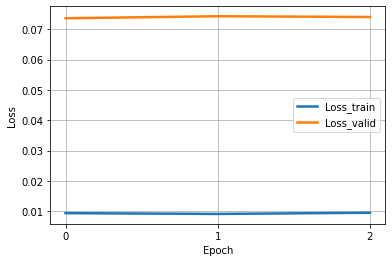

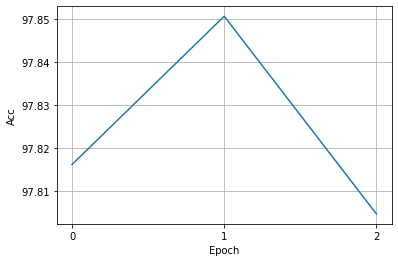

In [ ]:
plot_train(history)

In [ ]:
load_model(model_tf_inception_v3)

###TEST

In [ ]:
test_loader = dm.test_dataloader()
y_pred, y_true = test(model_tf_inception_v3, nn.CrossEntropyLoss().to(device), device, test_loader)

Test set: Average loss: 	0.4527
Test set: Accuracy score:	0.6540229885057471
Test set: Macro F1 score:	0.656369370890488


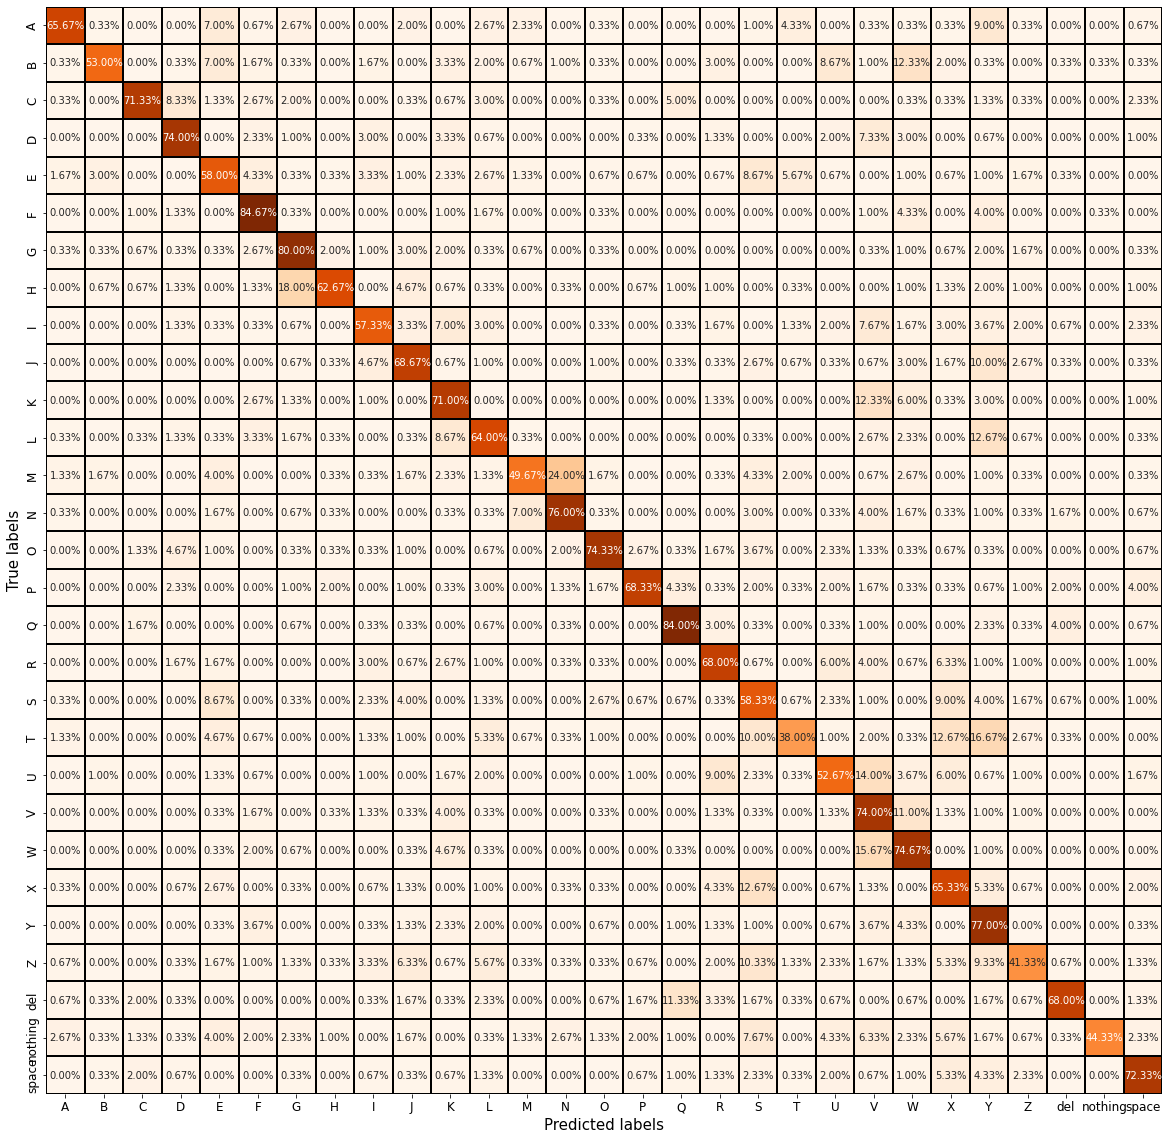

In [ ]:
confusionMatrix (y_pred, y_true, dm)

##custom_1

###TRAIN

In [ ]:
num_class  = 29
lr         = 7e-4
num_epchs  = 5
batch_size = 256
img_size   = 200
base_dir   = "/content/output"
save_sec_dir = DRIVE_PATH.replace('\\',"")
criterion  = nn.CrossEntropyLoss().to(device)

In [ ]:
import gc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(47)

In [ ]:
gc.collect()
torch.cuda.empty_cache()
torch.set_grad_enabled(True)

In [ ]:
block = {
    "layers":[nn.Conv2d(3, 16, 5, 1, 2),
              nn.ReLU(),
              nn.MaxPool2d(2),
              nn.Conv2d(16, 32, 5, 1, 2),
              nn.ReLU(),
              nn.MaxPool2d(2),
              nn.Flatten(),
              nn.LazyLinear(1024),
              nn.ReLU(),
              nn.Linear(1024, 512),
              nn.ReLU()],
    "tail": 512}

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
model_custom_1 = CNN_train("custom_1",block,num_classes=num_class,sec_dir = save_sec_dir).to(device)

In [ ]:
#optimizer =  torch.optim.Adam(model_custom_1.parameters(), lr=lr)
optimizer =  torch.optim.SGD(model_custom_1.parameters(), lr=lr, momentum=0.9)
dm = DataModule(model_custom_1.get_mean_std(), data_dir = base_dir, img_size = img_size, batch_size=batch_size)
dm.setup()
train_loader = dm.train_dataloader()
valid_loader = dm.val_dataloader()

train

In [ ]:
max_acc_custom_1 = 99.85057471264368

In [ ]:
model_custom_1, history = train(model_custom_1, criterion, device, train_loader, valid_loader, optimizer, num_epchs, max_acc = max_acc_custom_1)

Begin training...
APLICANDO TRANSFER LEARNING. 
 Entrenando Bloque añadido.
Train Epoch: 1 [0/69600 (0%)]	Loss: 0.000172
Train Epoch: 1 [2560/69600 (4%)]	Loss: 0.000768
Train Epoch: 1 [5120/69600 (7%)]	Loss: 0.000651
Train Epoch: 1 [7680/69600 (11%)]	Loss: 0.000302
Train Epoch: 1 [10240/69600 (15%)]	Loss: 0.001722
Train Epoch: 1 [12800/69600 (18%)]	Loss: 0.000758
Train Epoch: 1 [15360/69600 (22%)]	Loss: 0.001400
Train Epoch: 1 [17920/69600 (26%)]	Loss: 0.000252
Train Epoch: 1 [20480/69600 (29%)]	Loss: 0.000162
Train Epoch: 1 [23040/69600 (33%)]	Loss: 0.000253
Train Epoch: 1 [25600/69600 (37%)]	Loss: 0.000659
Train Epoch: 1 [28160/69600 (40%)]	Loss: 0.002094
Train Epoch: 1 [30720/69600 (44%)]	Loss: 0.003058
Train Epoch: 1 [33280/69600 (48%)]	Loss: 0.000207
Train Epoch: 1 [35840/69600 (51%)]	Loss: 0.000645
Train Epoch: 1 [38400/69600 (55%)]	Loss: 0.000299
Train Epoch: 1 [40960/69600 (59%)]	Loss: 0.000874
Train Epoch: 1 [43520/69600 (62%)]	Loss: 0.000618
Train Epoch: 1 [46080/69600 (66%)]

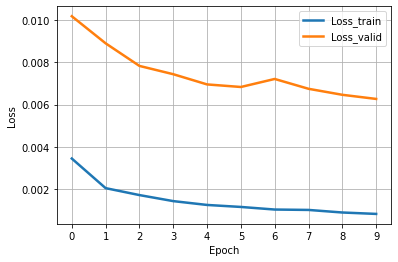

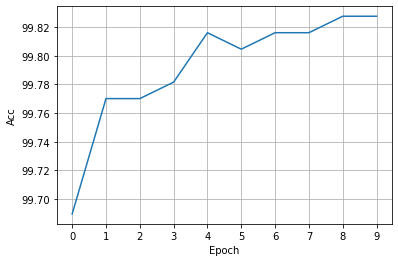

0.9982758620689656


In [ ]:
max_acc_custom_1 = plot_train(history)
print(max_acc_custom_1)

In [ ]:
load_model(model_custom_1)

###TEST

In [ ]:
test_loader = dm.test_dataloader()
y_pred, y_true = test(model_custom_1, nn.CrossEntropyLoss().to(device), device, test_loader)

Test set: Average loss: 	0.0006
Test set: Accuracy score:	0.9980459770114942
Test set: Macro F1 score:	0.998046731812367


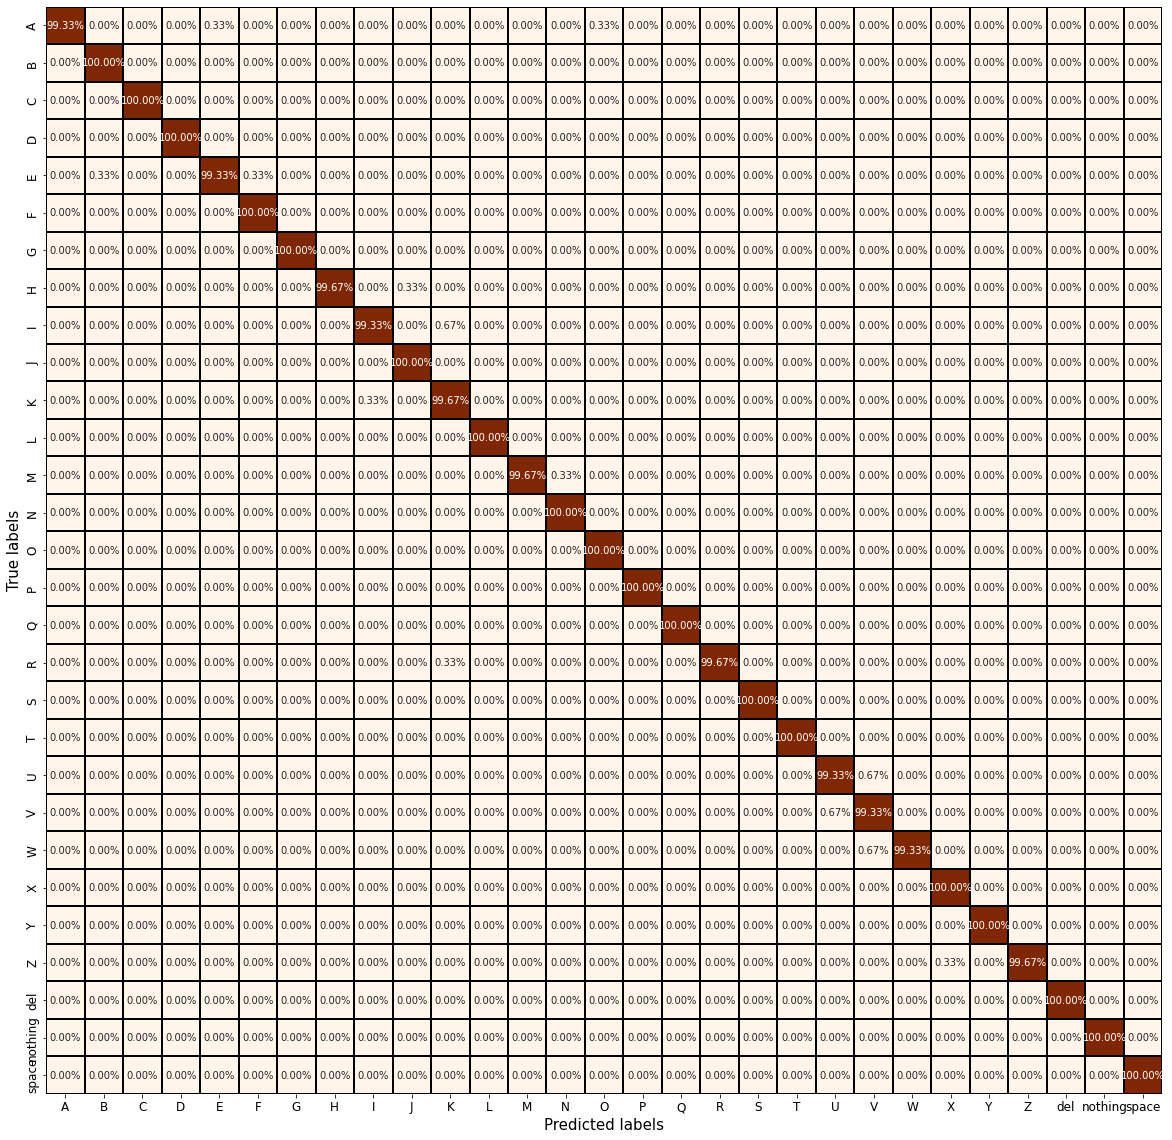

In [ ]:
confusionMatrix (y_pred, y_true, dm)

## tf_efficientnet_b3_ns

###TRAIN

In [ ]:
num_class  = 29
lr         = 0.5e-3
num_epchs  = 10
batch_size = 128
img_size   = 300
base_dir   = "/content/output"
save_sec_dir = DRIVE_PATH.replace('\\',"")
criterion  = nn.CrossEntropyLoss().to(device)

In [ ]:
import gc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(47)

In [ ]:
gc.collect()
torch.cuda.empty_cache()
torch.set_grad_enabled(True)

In [ ]:
block = {
    "layers":[nn.Linear(1024, 512),
              nn.ReLU(),
              nn.Linear(512, 256),
              nn.ReLU(),
              nn.Linear(256, 128),
              nn.ReLU()],
    "head": 1024,
    "tail": 128}

In [ ]:
model_tf_efficientnet_b3_ns = CNN_pretrained("tf_efficientnet_b3_ns",block,num_classes=num_class,sec_dir = save_sec_dir).to(device)

In [ ]:
#optimizer =  torch.optim.Adam(model_tf_efficientnet_b3_ns.parameters(), lr=lr)
optimizer =  torch.optim.SGD(model_tf_efficientnet_b3_ns.parameters(), lr=lr, momentum=0.9)
dm = DataModule(model_tf_efficientnet_b3_ns.get_mean_std(), data_dir = base_dir, img_size = img_size, batch_size=batch_size)
dm.setup()
train_loader = dm.train_dataloader()
valid_loader = dm.val_dataloader()

train

In [ ]:
max_acc_tf_efficientnet_b3_ns = 99.67816091954024

In [ ]:
model_tf_efficientnet_b3_ns, history = train(model_tf_efficientnet_b3_ns, criterion, device, train_loader, valid_loader, optimizer, num_epchs, porc = 0.08, max_acc = max_acc_tf_efficientnet_b3_ns)

Begin training...
APLICANDO FINE TUNING. 
 Descongelando el 8.0% de capas.
Train Epoch: 1 [0/69600 (0%)]	Loss: 0.003178
Train Epoch: 1 [1280/69600 (2%)]	Loss: 0.003336
Train Epoch: 1 [2560/69600 (4%)]	Loss: 0.007003
Train Epoch: 1 [3840/69600 (6%)]	Loss: 0.001127
Train Epoch: 1 [5120/69600 (7%)]	Loss: 0.000674
Train Epoch: 1 [6400/69600 (9%)]	Loss: 0.001433
Train Epoch: 1 [7680/69600 (11%)]	Loss: 0.001765
Train Epoch: 1 [8960/69600 (13%)]	Loss: 0.005383
Train Epoch: 1 [10240/69600 (15%)]	Loss: 0.000697
Train Epoch: 1 [11520/69600 (17%)]	Loss: 0.001340
Train Epoch: 1 [12800/69600 (18%)]	Loss: 0.001276
Train Epoch: 1 [14080/69600 (20%)]	Loss: 0.005540
Train Epoch: 1 [15360/69600 (22%)]	Loss: 0.000496
Train Epoch: 1 [16640/69600 (24%)]	Loss: 0.000958
Train Epoch: 1 [17920/69600 (26%)]	Loss: 0.000763
Train Epoch: 1 [19200/69600 (28%)]	Loss: 0.000933
Train Epoch: 1 [20480/69600 (29%)]	Loss: 0.013781
Train Epoch: 1 [21760/69600 (31%)]	Loss: 0.003825
Train Epoch: 1 [23040/69600 (33%)]	Loss: 0

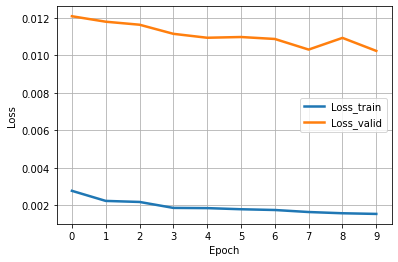

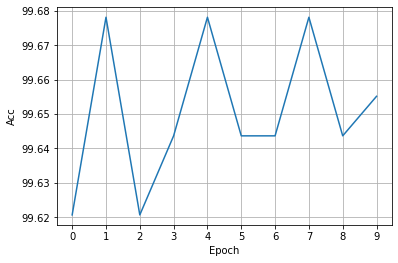

0.9967816091954024


In [ ]:
max_acc_tf_efficientnet_b3_ns = plot_train(history)
print(max_acc_tf_efficientnet_b3_ns)

In [ ]:
load_model(model_tf_efficientnet_b3_ns)

###TEST

In [ ]:
test_loader = dm.test_dataloader()
y_pred, y_true = test(model_tf_efficientnet_b3_ns, nn.CrossEntropyLoss().to(device), device, test_loader)

Test set: Average loss: 	0.0001
Test set: Accuracy score:	0.9949425287356322
Test set: Macro F1 score:	0.9949379809544187


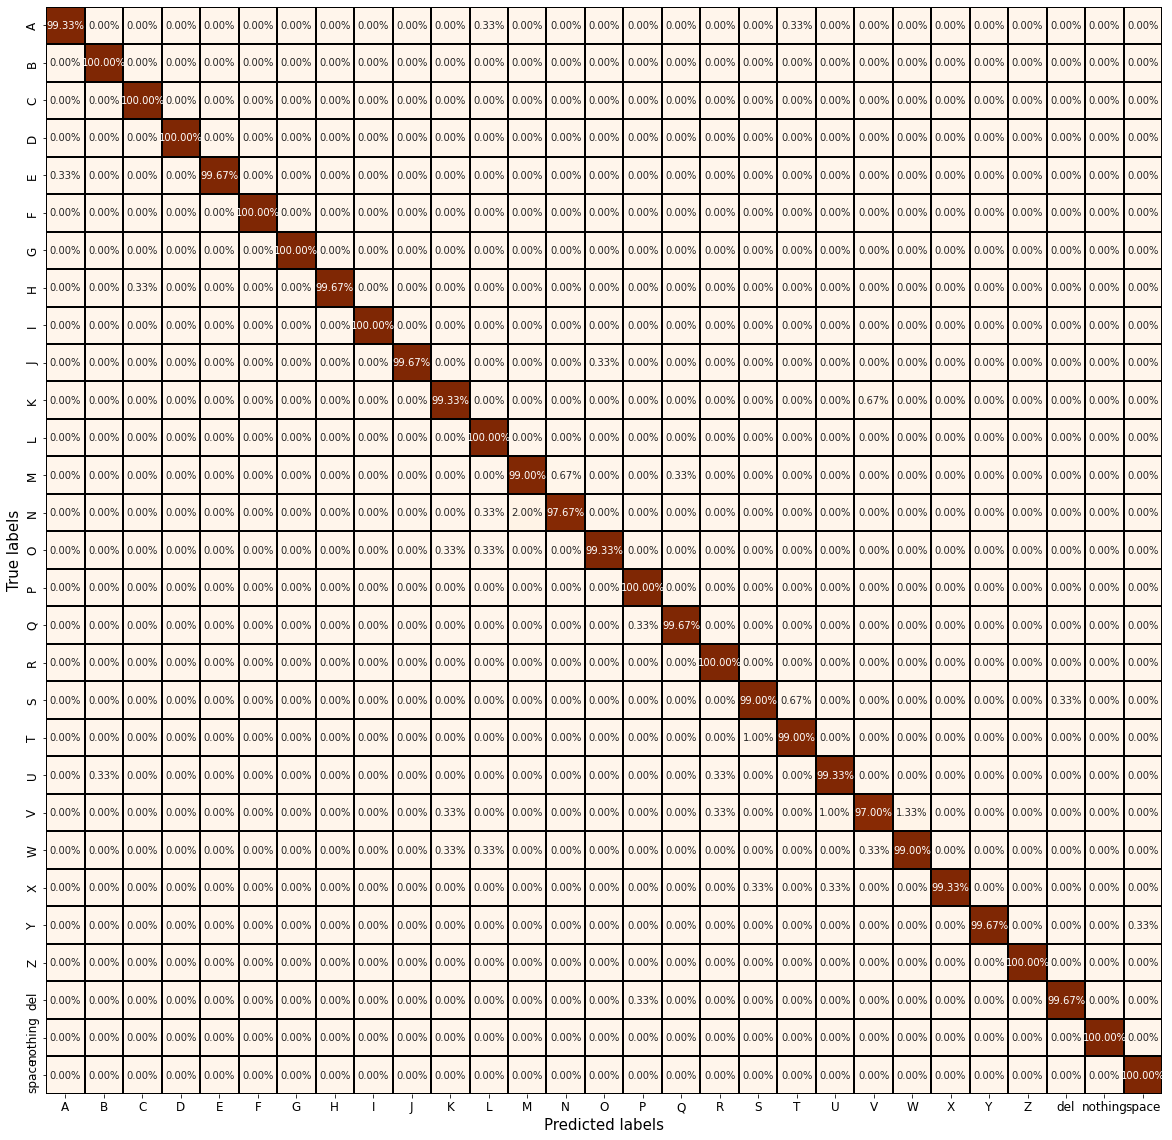

In [ ]:
confusionMatrix (y_pred, y_true, dm)